In [ ]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


ModuleNotFoundError: No module named 'plot'

In [2]:

# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [5]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)


In [6]:
cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


In [ ]:

# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
# mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
# mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


In [ ]:
def top_10_percent_indices(activity):
    """
    Get the indices of the top 10% most active neurons.
    :param activity: Array of mean activity (trials x neurons or reactivations x neurons)
    :return: Set of indices of the top 10% neurons
    """
    mean_activity = activity.mean(axis=0)  # Average across trials/reactivations
    threshold = np.percentile(mean_activity, 90)  # Top 10% threshold
    top_indices = np.where(mean_activity >= threshold)[0]  # Indices of top 10%
    return set(top_indices)


# Compute top 10% neuron indices
top_cs_1_indices = top_10_percent_indices(mean_activity_cs_1)
top_cs_2_indices = top_10_percent_indices(mean_activity_cs_2)
top_r_1_indices = top_10_percent_indices(mean_activity_r_1)
top_r_2_indices = top_10_percent_indices(mean_activity_r_2)

# Compare overlaps
def compute_overlap(set1, set2):
    """
    Compute overlap between two sets of indices.
    :param set1: Set of indices
    :param set2: Set of indices
    :return: Fractional overlap (intersection size / union size)
    """
    intersection = set1 & set2
    union = set1 | set2
    return len(intersection), len(union), len(intersection) / len(union)  # Overlap, total size, Jaccard index


# Compare and print overlaps
overlap_cs1_r1 = compute_overlap(top_cs_1_indices, top_r_1_indices)
overlap_cs2_r2 = compute_overlap(top_cs_2_indices, top_r_2_indices)
overlap_cs1_cs2 = compute_overlap(top_cs_1_indices, top_cs_2_indices)
overlap_r1_r2 = compute_overlap(top_r_1_indices, top_r_2_indices)
overlap_cs1_r2 = compute_overlap(top_cs_1_indices, top_r_2_indices)
overlap_cs2_r1 = compute_overlap(top_cs_2_indices, top_r_1_indices)

print(f"Overlap between CS_1 and R_1: {overlap_cs1_r1[0]} / {overlap_cs1_r1[1]} (Jaccard: {overlap_cs1_r1[2]:.2f})")
print(f"Overlap between CS_2 and R_2: {overlap_cs2_r2[0]} / {overlap_cs2_r2[1]} (Jaccard: {overlap_cs2_r2[2]:.2f})")
print(f"Overlap between CS_1 and CS_2: {overlap_cs1_cs2[0]} / {overlap_cs1_cs2[1]} (Jaccard: {overlap_cs1_cs2[2]:.2f})")
print(f"Overlap between R_1 and R_2: {overlap_r1_r2[0]} / {overlap_r1_r2[1]} (Jaccard: {overlap_r1_r2[2]:.2f})")
print(f"Overlap between CS_1 and R_2: {overlap_cs1_r2[0]} / {overlap_cs1_r2[1]} (Jaccard: {overlap_cs1_r2[2]:.2f})")
print(f"Overlap between CS_2 and R_1: {overlap_cs2_r1[0]} / {overlap_cs2_r1[1]} (Jaccard: {overlap_cs2_r1[2]:.2f})")

#print(top_cs_1_indices)


Overlap between CS_1 and R_1: 32 / 594 (Jaccard: 0.05)
Overlap between CS_2 and R_2: 26 / 600 (Jaccard: 0.04)
Overlap between CS_1 and CS_2: 0 / 626 (Jaccard: 0.00)
Overlap between R_1 and R_2: 234 / 392 (Jaccard: 0.60)
Overlap between CS_1 and R_2: 28 / 598 (Jaccard: 0.05)
Overlap between CS_2 and R_1: 22 / 604 (Jaccard: 0.04)


In [12]:
# Identify overlapping and unique neurons
overlap_neurons = list(top_r_1_indices & top_r_2_indices)
unique_r1 = list(top_r_1_indices - top_r_2_indices)
unique_r2 = list(top_r_2_indices - top_r_1_indices)

overlap_activity_r_1 = mean_activity_r_1[:, overlap_neurons]  # Reactivations x Overlapping Neurons
overlap_activity_r_2 = mean_activity_r_2[:, overlap_neurons]

overlap_activity_cs_1 = mean_activity_cs_1[:, overlap_neurons]  # Trials x Overlapping Neurons
overlap_activity_cs_2 = mean_activity_cs_2[:, overlap_neurons]

In [15]:
def compute_drift_per_trial(activity_matrix):
    """
    Compute drift (current trial - previous trial) for each neuron.
    :param activity_matrix: Trials x Neurons matrix of activity
    :return: Drift matrix (Trials-1 x Neurons)
    """
    return activity_matrix[1:, :] - activity_matrix[:-1, :]

drift_cs_1 = compute_drift_per_trial(mean_activity_cs_1)  # Shape: (trials-1, neurons)
drift_cs_2 = compute_drift_per_trial(mean_activity_cs_2)  # Shape: (trials-1, neurons)


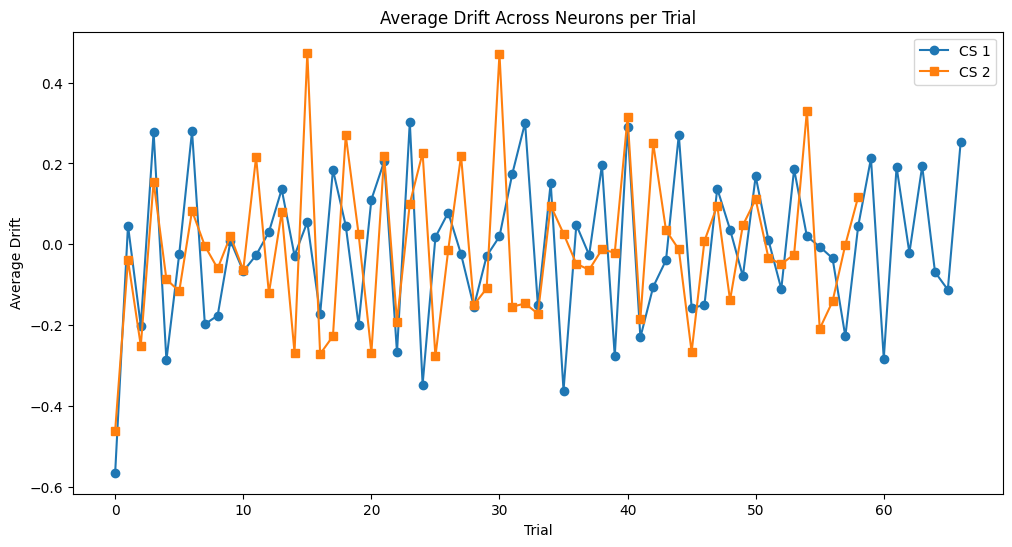

In [17]:
# Compute average drift per trial for CS 1 and CS 2
mean_drift_cs_1 = drift_cs_1.mean(axis=1)
mean_drift_cs_2 = drift_cs_2.mean(axis=1)

# Plot average drift across trials
plt.figure(figsize=(12, 6))
plt.plot(mean_drift_cs_1, label="CS 1", marker="o")
plt.plot(mean_drift_cs_2, label="CS 2", marker="s")
plt.title("Average Drift Across Neurons per Trial")
plt.xlabel("Trial")
plt.ylabel("Average Drift")
plt.legend()
plt.show()


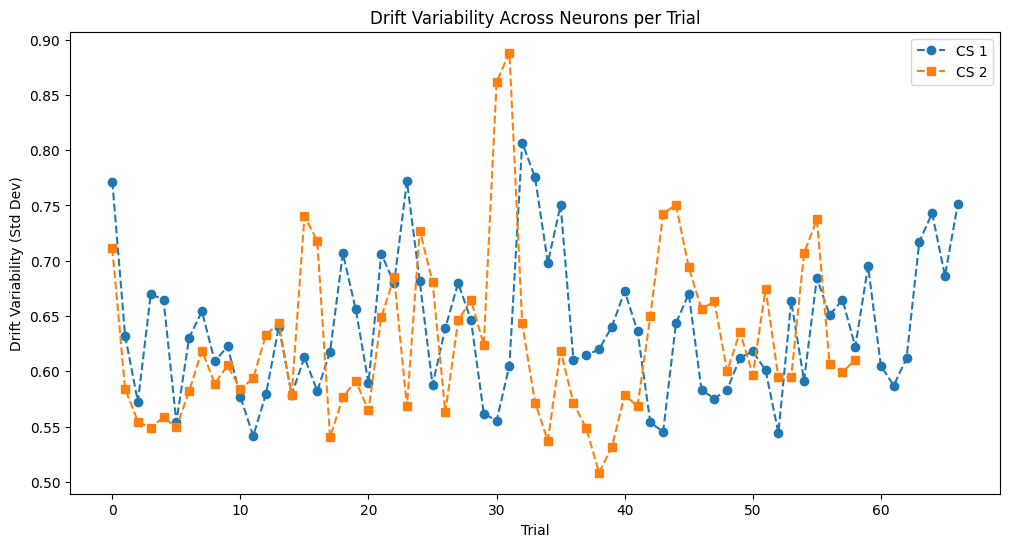

In [18]:
# Compute standard deviation of drift per trial for CS 1 and CS 2
std_drift_cs_1 = drift_cs_1.std(axis=1)
std_drift_cs_2 = drift_cs_2.std(axis=1)

# Plot drift variability across trials
plt.figure(figsize=(12, 6))
plt.plot(std_drift_cs_1, label="CS 1", marker="o", linestyle="--")
plt.plot(std_drift_cs_2, label="CS 2", marker="s", linestyle="--")
plt.title("Drift Variability Across Neurons per Trial")
plt.xlabel("Trial")
plt.ylabel("Drift Variability (Std Dev)")
plt.legend()
plt.show()


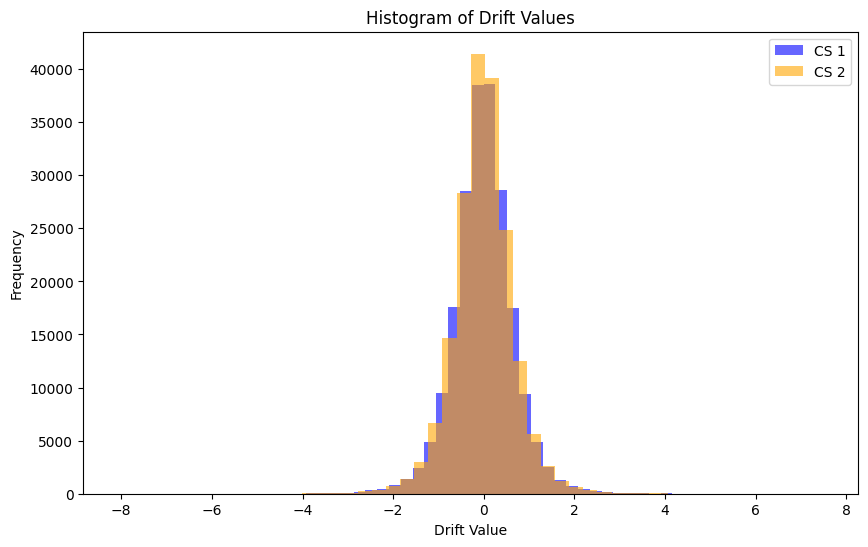

In [19]:
# Flatten drift matrices to 1D arrays
drift_values_cs_1 = drift_cs_1.flatten()
drift_values_cs_2 = drift_cs_2.flatten()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(drift_values_cs_1, bins=50, alpha=0.6, label="CS 1", color="blue")
plt.hist(drift_values_cs_2, bins=50, alpha=0.6, label="CS 2", color="orange")
plt.title("Histogram of Drift Values")
plt.xlabel("Drift Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


MSE: 0.0209, R-squared: 0.3901


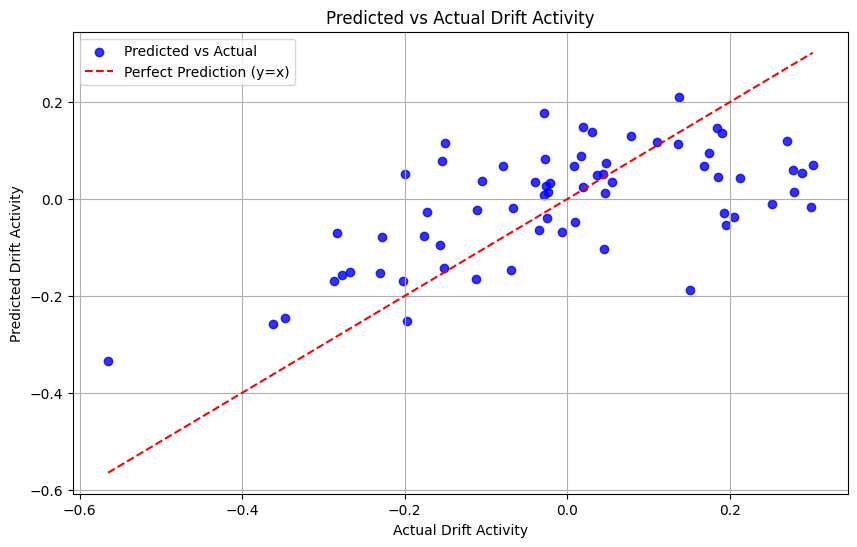

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

mean_drift_cs_1 = drift_cs_1.mean(axis=1)  # Mean across neurons for each trial
mean_overlap_cs_1 = overlap_activity_cs_1[:-1, ].mean(axis=1)

# Reshape data for regression
X = mean_overlap_cs_1.reshape(-1, 1)  # Input: Overlapping activity
y = mean_drift_cs_1  # Output: Drift activity

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict drift activity
predicted_drift = model.predict(X)

mse = mean_squared_error(y, predicted_drift)
r2 = r2_score(y, predicted_drift)
print(f"MSE: {mse:.4f}, R-squared: {r2:.4f}")

# Visualize predictions vs actual drift activity
plt.figure(figsize=(10, 6))
plt.scatter(y.flatten(), predicted_drift.flatten(), alpha=0.8, color = 'blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift Activity")
plt.xlabel("Actual Drift Activity")
plt.ylabel("Predicted Drift Activity")
plt.legend()
plt.grid()
plt.show()


In [71]:
print(overlap_activity_cs_1.shape)
print(drift_cs_1.shape)

variance = np.var(drift_cs_1)
print(f"Variance of drift dataset: {variance:.4f}")



(68, 234)
(67, 3124)
Variance of drift dataset: 0.4463


MSE: 0.0000
R-squared: 1.0000
Model coefficients: [[-0.02204052 -0.0026836  -0.0022383  ...  0.04587629  0.00480015
   0.03713468]
 [-0.015493   -0.01699456 -0.00416241 ... -0.00141583  0.0325053
  -0.01405153]
 [ 0.00400264 -0.02782551 -0.0016145  ... -0.03528136  0.05398673
  -0.01038586]
 ...
 [ 0.04558125 -0.07249963 -0.01606147 ...  0.05546267  0.04373544
  -0.02235037]
 [-0.00040511 -0.08787934 -0.15225452 ...  0.10007722 -0.20610625
   0.07906947]
 [ 0.05350546 -0.07840585  0.02920817 ... -0.10604857 -0.03661009
   0.00180502]]
Model intercept: [ 0.14261317  0.35622234  0.15637549 ...  0.51638434 -0.72025815
  0.55011105]


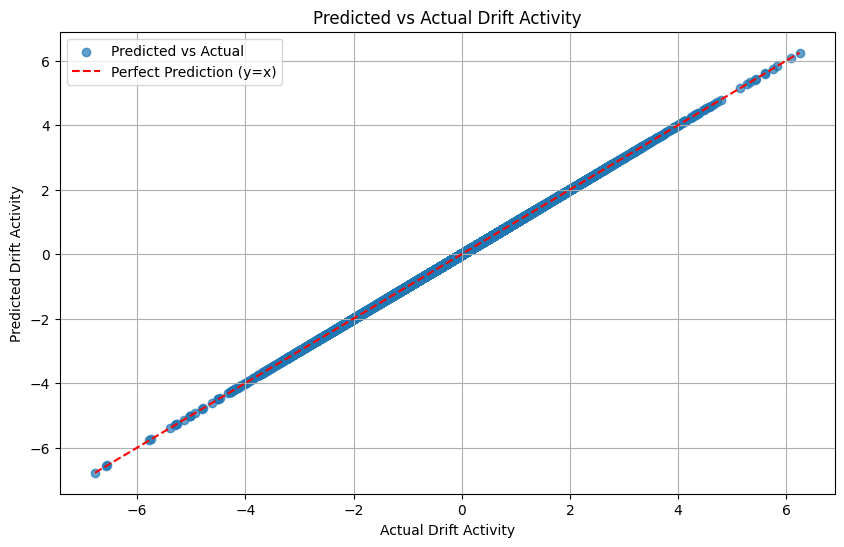

In [ ]:
# Flatten or reshape the datasets if needed
# Assuming drift_cs_1 and overlapping_activity_cs_1 are already aligned and have the same shape (trials × neurons)
X = overlap_activity_cs_1[:-1, ]  # Use overlapping activity as input
y = drift_cs_1  # Use drift activity as the target

# Fit the regression model
model = LinearRegression()
model.fit(X, y)

# Predict drift activity
predicted_drift = model.predict(X)

# Evaluate performance
mse = mean_squared_error(y, predicted_drift)
r2 = r2_score(y, predicted_drift)

print(f"MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
#print("Model coefficients:", model.coef_)
#print("Model intercept:", model.intercept_)


# Visualize predictions vs actual drift activity
plt.figure(figsize=(10, 6))
plt.scatter(y.flatten(), predicted_drift.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift Activity")
plt.xlabel("Actual Drift Activity")
plt.ylabel("Predicted Drift Activity")
plt.legend()
plt.grid()
plt.show()


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on training data
model.fit(X_train, y_train)

# Predict on testing data
y_test_pred = model.predict(X_test)

# Evaluate on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")


Test MSE: 0.7327
Test R-squared: -0.8688


In [79]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_test_pred = model.predict(X_test)

# Evaluate performance
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")


Test MSE: 0.4822
Test R-squared: -0.1394


In [ ]:
from scipy.stats import t
# Group reactivations by trial indices
unique_trials_r1 = np.unique(trial_r_1)
unique_trials_r2 = np.unique(trial_r_2)

print(unique_trials_r1)

# Average r1 and r2 activity for each trial
mean_activity_r1_per_trial = np.zeros((len(unique_trials_r1), mean_activity_r_1.shape[1]))
mean_activity_r2_per_trial = np.zeros((len(unique_trials_r2), mean_activity_r_2.shape[1]))

for i, trial in enumerate(unique_trials_r1):
    trial_indices = np.where(trial_r_1 == trial)[0]
    mean_activity_r1_per_trial[i, :] = mean_activity_r_1[trial_indices, :].mean(axis=0)

for i, trial in enumerate(unique_trials_r2):
    trial_indices = np.where(trial_r_2 == trial)[0]
    mean_activity_r2_per_trial[i, :] = mean_activity_r_2[trial_indices, :].mean(axis=0)

# Step 2: Ensure alignment with drift datasets
# Align trials in drift_cs_1 and mean_activity_r1_per_trial
aligned_indices_r1 = np.isin(unique_trials_r1, np.arange(drift_cs_1.shape[0]))
aligned_indices_r2 = np.isin(unique_trials_r2, np.arange(drift_cs_2.shape[0]))

mean_activity_r1_aligned = mean_activity_r1_per_trial[aligned_indices_r1, :]
mean_activity_r2_aligned = mean_activity_r2_per_trial[aligned_indices_r2, :]

drift_cs_1_aligned = drift_cs_1[unique_trials_r1[aligned_indices_r1], :]
cs_2_aligned = drift_cs_2[unique_trials_r2[aligned_indices_r2], :]

# Step 3: Compute correlations for each neuron
# Compute correlations between r1 activity and drift_cs_1
correlations_r1 = [
    np.corrcoef(mean_activity_r1_aligned[:, neuron], drift_cs_1_aligned[:, neuron])[0, 1]
    for neuron in range(mean_activity_r1_aligned.shape[1])
]

# Compute correlations between r2 activity and cs_2
correlations_r2 = [
    np.corrcoef(mean_activity_r2_aligned[:, neuron], cs_2_aligned[:, neuron])[0, 1]
    for neuron in range(mean_activity_r2_aligned.shape[1])
]

def correlation_p_value(r, n):
    """Compute the p-value for a given correlation coefficient."""
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * t.sf(np.abs(t_stat), df=n - 2)  # Two-tailed test
    return p_value

# Step 1: Compute p-values for r1
num_trials = mean_activity_r1_aligned.shape[0]
p_values_r1 = [correlation_p_value(r, num_trials) for r in correlations_r1]

# Step 2: Compute p-values for r2
num_trials_r2 = mean_activity_r2_aligned.shape[0]
p_values_r2 = [correlation_p_value(r, num_trials_r2) for r in correlations_r2]

# Step 3: Identify significant neurons
significant_neurons_r1 = [neuron for neuron, p in enumerate(p_values_r1) if p < 0.05]
significant_neurons_r2 = [neuron for neuron, p in enumerate(p_values_r2) if p < 0.05]

# Step 4: Print significant neurons
print(f"Significant neurons from r1: {len(significant_neurons_r1)} out of {len(correlations_r1)}")
print(f"Significant neurons from r2: {len(significant_neurons_r2)} out of {len(correlations_r2)}")




[ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Significant neurons from r1: 279 out of 3124
Significant neurons from r2: 167 out of 3124


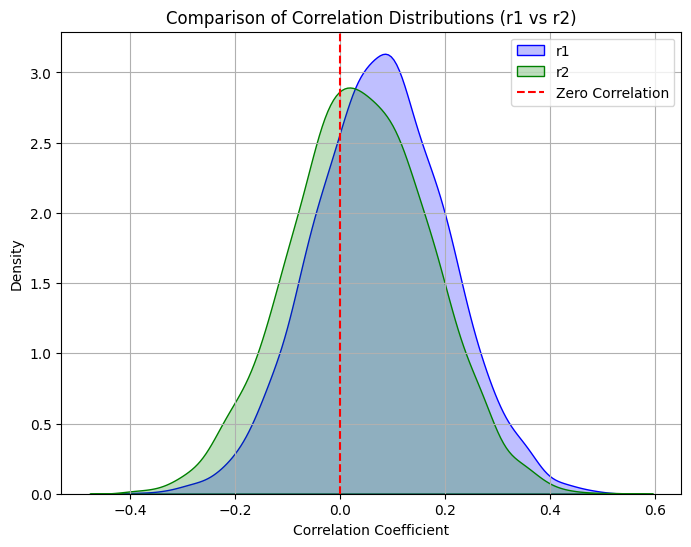

In [98]:
all_correlations = {
    "r1": correlations_r1,
    "r2": correlations_r2,
}

plt.figure(figsize=(8, 6))
sns.kdeplot(correlations_r1, shade=True, label="r1", color='blue')
sns.kdeplot(correlations_r2, shade=True, label="r2", color='green')
plt.axvline(x=0, color='red', linestyle='--', label="Zero Correlation")
plt.title("Comparison of Correlation Distributions (r1 vs r2)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()



significant_neurons_r1 vs significant_neurons_r2: Intersection = 16, Union = 430, Overlap = 3.72%
significant_neurons_r1 vs overlap_neurons: Intersection = 31, Union = 482, Overlap = 6.43%
significant_neurons_r1 vs top_r_1_indices: Intersection = 44, Union = 548, Overlap = 8.03%
significant_neurons_r1 vs top_cs_1_indices: Intersection = 27, Union = 565, Overlap = 4.78%
significant_neurons_r1 vs top_r_2_indices: Intersection = 39, Union = 553, Overlap = 7.05%
significant_neurons_r1 vs top_cs_2_indices: Intersection = 26, Union = 566, Overlap = 4.59%
significant_neurons_r2 vs overlap_neurons: Intersection = 17, Union = 384, Overlap = 4.43%
significant_neurons_r2 vs top_r_1_indices: Intersection = 19, Union = 461, Overlap = 4.12%
significant_neurons_r2 vs top_cs_1_indices: Intersection = 16, Union = 464, Overlap = 3.45%
significant_neurons_r2 vs top_r_2_indices: Intersection = 23, Union = 457, Overlap = 5.03%
significant_neurons_r2 vs top_cs_2_indices: Intersection = 5, Union = 475, Overl

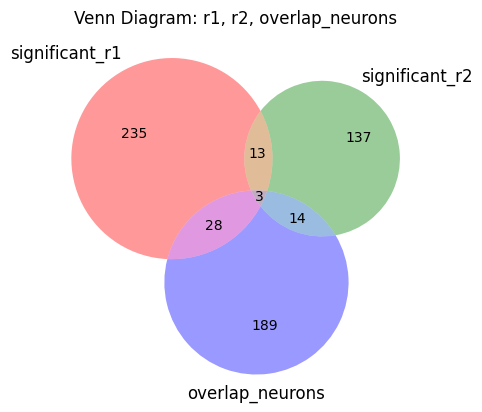

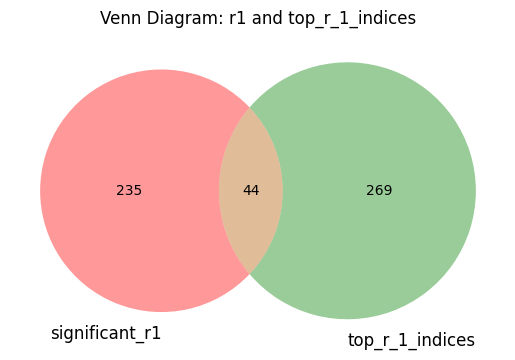

In [ ]:
import itertools
from matplotlib_venn import venn3, venn2

# Step 1: Convert neuron lists to sets
sets = {
    "significant_neurons_r1": set(significant_neurons_r1),
    "significant_neurons_r2": set(significant_neurons_r2),
    "overlap_neurons": set(overlap_neurons),
    "top_r_1_indices": set(top_r_1_indices),
    "top_cs_1_indices": set(top_cs_1_indices),
    "top_r_2_indices": set(top_r_2_indices),
    "top_cs_2_indices": set(top_cs_2_indices),
    ""
}

# Step 2: Compare all pairwise overlaps
comparison_results = {}
for (set_name_1, set_1), (set_name_2, set_2) in itertools.combinations(sets.items(), 2):
    intersection = set_1 & set_2
    union = set_1 | set_2
    comparison_results[(set_name_1, set_name_2)] = {
        "intersection_count": len(intersection),
        "union_count": len(union),
        "overlap_percentage": len(intersection) / len(union) * 100 if len(union) > 0 else 0,
    }

# Print pairwise comparison results
for pair, result in comparison_results.items():
    print(f"{pair[0]} vs {pair[1]}: "
          f"Intersection = {result['intersection_count']}, "
          f"Union = {result['union_count']}, "
          f"Overlap = {result['overlap_percentage']:.2f}%")

# Step 3: Visualize overlaps (Venn diagrams for selected comparisons)
# Example: Venn diagram for significant_neurons_r1, significant_neurons_r2, and overlap_neurons
venn3([
    sets["significant_neurons_r1"],
    sets["significant_neurons_r2"],
    sets["overlap_neurons"],
], set_labels=("significant_r1", "significant_r2", "overlap_neurons"))
plt.title("Venn Diagram: r1, r2, overlap_neurons")
plt.show()

# Example: Venn diagram for significant_neurons_r1 and top_r_1_indices
venn2([
    sets["significant_neurons_r1"],
    sets["top_r_1_indices"],
], set_labels=("significant_r1", "top_r_1_indices"))
plt.title("Venn Diagram: r1 and top_r_1_indices")
plt.show()


In [110]:
# Step 4: Compare all possible combinations
from functools import reduce

for combination_size in range(2, len(sets) + 1):
    for combination in itertools.combinations(sets.items(), combination_size):
        combination_names = [name for name, _ in combination]
        combined_set = reduce(lambda x, y: x & y, [s for _, s in combination])
        print(f"Intersection of {combination_names}: {len(combined_set)} neurons")


Intersection of ['significant_neurons_r1', 'significant_neurons_r2']: 16 neurons
Intersection of ['significant_neurons_r1', 'overlap_neurons']: 31 neurons
Intersection of ['significant_neurons_r1', 'top_r_1_indices']: 44 neurons
Intersection of ['significant_neurons_r1', 'top_cs_1_indices']: 27 neurons
Intersection of ['significant_neurons_r1', 'top_r_2_indices']: 39 neurons
Intersection of ['significant_neurons_r1', 'top_cs_2_indices']: 26 neurons
Intersection of ['significant_neurons_r2', 'overlap_neurons']: 17 neurons
Intersection of ['significant_neurons_r2', 'top_r_1_indices']: 19 neurons
Intersection of ['significant_neurons_r2', 'top_cs_1_indices']: 16 neurons
Intersection of ['significant_neurons_r2', 'top_r_2_indices']: 23 neurons
Intersection of ['significant_neurons_r2', 'top_cs_2_indices']: 5 neurons
Intersection of ['overlap_neurons', 'top_r_1_indices']: 234 neurons
Intersection of ['overlap_neurons', 'top_cs_1_indices']: 21 neurons
Intersection of ['overlap_neurons', 'top

In [1]:
print(significant_neurons_r1, significant_neurons_r2)

NameError: name 'significant_neurons_r1' is not defined